In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2
import random

#from image import ImageDataGenerator
import os

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('keras','numpy','matplotlib','cv2')

Using Theano backend.


keras: 1.1.1
numpy: 1.11.2
matplotlib: 1.5.1
cv2: 2.4.10


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


## Setting

In [2]:
# path to data
path2numpy = "./output/data/"
foldnm=1
path2nfolds=path2numpy+'fold'+str(foldnm)+'/'

h,w=128,128
experiment='fold'+str(foldnm)+'_cnn3d_hw_'+str(h)+'by'+str(w)
print 'experiment:', experiment

seed = 2017

sample_ena=False

experiment: fold1_cnn3d_hw_128by128


In [22]:

# functions
from keras.layers import Input, Convolution3D, MaxPooling3D, UpSampling2D,Dropout
from keras.layers import Activation,Reshape,Permute,Flatten,Dense
#from keras.layers.advanced_activations import ELU
from keras.utils import np_utils
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.models import Sequential
#from funcs.image import ImageDataGenerator


# model
def model(params):
    z=params['z']
    h=params['img_rows']
    w=params['img_cols']
    lr=params['learning_rate']
    weights_path=params['weights_path']
    loss=params['loss']
    C=params['nb_filters']
    num_labels=params['num_labels']
    
    
    model = Sequential()
    
    model.add(Convolution3D(C, 3,3, 3, activation='relu',border_mode='same', input_shape=(1,z, h, w)))

    N=5
    for k in range(1,N):
        ck=min([2**k*C,512])
        model.add(Convolution3D(ck, 3,3, 3, activation='relu', border_mode='same'))              
        model.add(Convolution3D(ck, 3,3, 3, activation='relu', border_mode='same'))              
        model.add(MaxPooling3D(pool_size=(2,2, 2)))
    
    model.add(Convolution3D(ck, 3,3, 3, activation='relu', border_mode='valid'))              
    #model.add(Convolution2D(2**k*C, 3, 3, activation='relu', border_mode='same'))              
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.1))

    model.add(Dense(num_labels, activation='softmax'))
    
    #load previous weights
    if weights_path:
        model.load_weights(weights_path)

    model.compile(loss=loss, optimizer=Adam(lr))

    return model


def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))

def image_with_mask(img, mask):
    maximg=np.max(img)
    mask=np.asarray(mask,dtype='uint8')
    if np.max(mask)<=1:
        mask=mask*255
    # returns a copy of the image with edges of the mask added in red
    img_color = grays_to_RGB(img)
    mask_edges = cv2.Canny(mask, 100, 200) > 0
    #print np.sum(mask_edges)
    img_color[mask_edges, 0] = maximg  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = 0
    img_color[mask_edges, 2] = 0
    img_color=img_color/float(np.max(img))
    return img_color

# 5D array image display
def disp_img_mask_5d(img,mask=None,ind=None):
    # img and mask are 5d arrays, N*time*C*H*W
    #img=np.squeeze(img)
    
    # check for random dispaly or based on input
    if ind is None:
        n1=np.random.randint(img.shape[0])
    else:
        n1=ind

    I1=img[n1]
    print I1.shape
    
    if mask is None:
        M1=np.zeros(I1.shape,dtype='uint8')
    else:
        mask=np.squeeze(mask)
        M1=mask[n1,:]
    print M1.shape
    
    r,c=2,5
    for k in range(r*c):
        plt.subplot(r,c,k+1)
        imgmask=image_with_mask(I1[k,:],M1[k,:])
        plt.imshow(imgmask)
        plt.title('s: %s, maxI: %s' %(n1,np.max(I1[k,:])))
    plt.show()

# sample
def disp_img_mask(img,mask=None,r=1,c=1,shuffle=False,d=0):
    if mask is None:
        mask=np.zeros_like(img)
    
    N=np.min([r*c,img.shape[0]])
    if d==2:
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        mask=np.transpose(mask,(2,0,1))
        mask=np.expand_dims(mask,axis=1)
    
    if len(img.shape)==3:
        img=np.expand_dims(img,axis=1)
        mask=np.expand_dims(mask,axis=1)

        
    if shuffle is True:
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=range(0,N)
    
    #if d==0:    
    I1=img[n1,0]
    #M1=mask[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask.shape[1]):
        M1=np.logical_or(M1,mask[n1,c1,:])    
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k])
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    return n1        
    
    
# preprocess
def preprocess(Xin,param_prep):
    # Xin is list of arrays N *H *W
    
    # get params
    h=param_prep['img_rows']
    w=param_prep['img_cols']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    z=param_prep['z']    
    
    Xout=np.empty((0,1,z,h,w),dtype='float32')
    N=len(Xin)
    for n in range(N):
        X=Xin[n]
        H,W=X.shape[1:]
        
        # center crop h*w
        if crop is 'center':
            hc=(H-h)/2
            wc=(W-w)/2
            X=X[:,hc:H-hc,wc:W-wc]
        elif crop is 'random':
            hc=(H-h)/2
            wc=(W-w)/2
            hcr=np.random.randint(hc)
            wcr=np.random.randint(wc)
            X=X[:,hc:H-hc,wc:W-wc]
        
        # check if need to downsample
        H,W=X.shape[1:]
        # resize if needed
        if h<H:
            X_r=np.zeros([z,h,w],dtype=X.dtype)
            for k1 in range(len(X)):
                X_r[k1] = cv2.resize(X[k1], (w, h), interpolation=cv2.INTER_CUBIC)
        else:
            X_r=X
    
        # normalization
        X_r=np.array(X_r,dtype='float32')
        if norm_type is 'global':
            #X_r=np.array(X_r,dtype='float32')
            X_r-=np.mean(X_r)
            X_r/=np.std(X_r)
        elif norm_type is 'local':
            for k in range(X_r.shape[0]):
                mean = np.mean(X_r[k,0])  # mean       
                sigma = np.std(X_r[k,0])  # std
                if sigma<1e-5:
                    sigma=1
                X_r[k] = X_r[k]-mean
                X_r[k] = X_r[k]/ sigma
        elif norm_type is 'scale':
            X_r-=np.min(X_r)
            X_r/=np.max(X_r)
            
        if z>X_r.shape[0]:
            X_r=np.append(X_r,np.zeros((z-X_r.shape[0],h,w),dtype='float32'),axis=0)
        else:
            z_random=np.random.randint(X_r.shape[0],size=z)
            X_r=X_r[z_random ]
            
        # X_r is z*h*w        
        # Xout is N*z*h*w
        Xout=np.append(Xout,X_r[np.newaxis,np.newaxis,:],axis=0)
    return Xout


def array_stats(*args):
    for X in args:
        X=np.asarray(X)
        print 'array shape: ',X.shape, X.dtype
        #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
        print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))


        


## load data

In [4]:
# load train data
print 'wait ...'
if sample_ena is False:
    f=np.load(path2nfolds + 'train.npz')
    X_train=f['X']
    y_train=f['Y']

    f=np.load(path2nfolds + 'test.npz')
    X_test=f['X']
    y_test=f['Y']
else:
    f=np.load(path2nfolds + 'train_sample.npz')
    X_train=f['X']
    y_train=f['Y']

    f=np.load(path2nfolds + 'test_sample.npz')
    X_test=f['X']
    y_test=f['Y']

    
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

wait ...
(1117,)
(1117,)
(280,)
(280,)


## hist of labels 

Train mean: 0.26
Test mean: 0.25


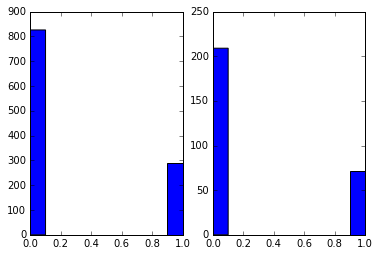

In [5]:
plt.subplot(121)
plt.hist(y_train)
plt.subplot(122)
plt.hist(y_test)

print 'Train mean: %.2f' %np.mean(y_train)
print 'Test mean: %.2f' %np.mean(y_test)

## select a portion for testing

In [18]:
if sample_ena:
    N1=24
    n1=np.random.randint(len(X_train),size=N1)
    X_train=X_train[n1]
    y_train=y_train[n1]
    print X_train.shape
    print y_train.shape

    N2=8
    n2=np.random.randint(len(X_test),size=N2)
    X_test=X_test[n2]
    y_test=y_test[n2]

    print X_test.shape
    print y_test.shape

(24,)
(24, 2)
(8,)
(8, 2)


In [7]:
# save sample    
#np.savez(path2nfolds+'train_sample.npz',X=X_train,Y=y_train)    
#np.savez(path2nfolds+'test_sample.npz',X=X_test,Y=y_test)    

## sample data

subject: 10
slices: [ 22  60  63  23  31  13   2 129]
wait ...


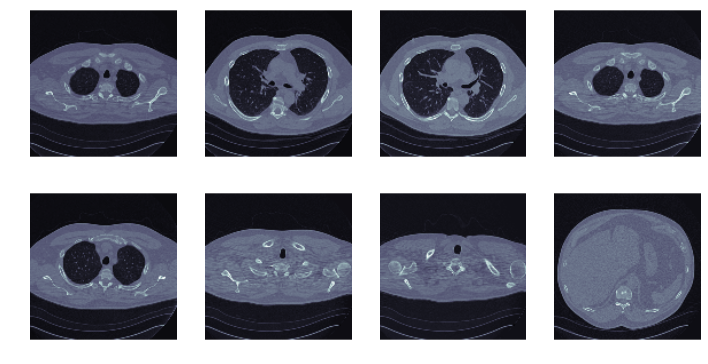

In [19]:
N_train=len(X_train)
N_test=len(X_test)

# display sample image
rnd_sbj=np.random.randint(N_train)
r,c=2,4
X=X_train[rnd_sbj]
nb_slices=len(X)
rnd_inds=np.random.randint(nb_slices,size=r*c)
print 'subject:', rnd_sbj
print 'slices:', rnd_inds
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
print 'wait ...'
for i in range(r*c):
    plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(X[rnd_inds[i]], cmap=plt.cm.bone)

wait ...
array shape:  (1, 1, 550, 128, 128) float32
min: -1.19996082783, max: 4.6413526535, avg: 9.33e-08, std:0.479
array shape:  (1, 1, 550, 128, 128) float32
min: -3.02370047569, max: 13.172706604, avg: -5.94e-08, std:0.562
array shape:  (24, 2) float64
min: 1.0, max: 1.0, avg: 1.0, std:0.0
array shape:  (8, 2) float64
min: 1.0, max: 1.0, avg: 1.0, std:0.0
(550, 128, 128)
550
subject: 10
slices: [193  16 403 297   2 130 258 193  42  27]
wait ...


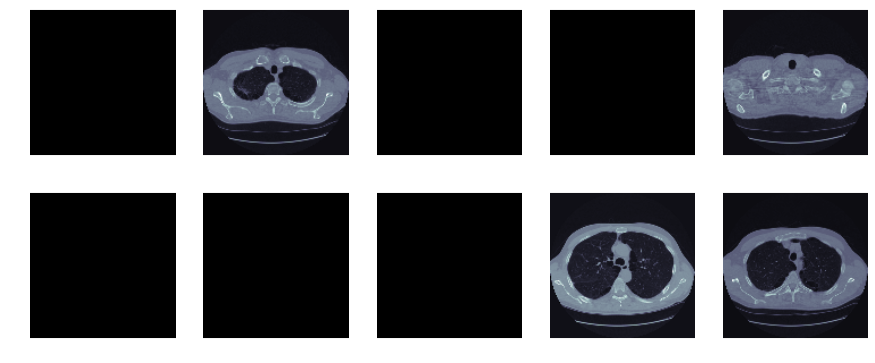

In [20]:
# pre-processing 
param_prep={
    'img_rows': 128,
    'img_cols': 128,
    'crop'    : None,
    'norm_type' : 'global',
    'z': 550,
}

print 'wait ...'
# preprocess train data
n1=3
step=1
X_train_r=preprocess(X_train[n1:n1+step],param_prep)
array_stats(X_train_r)

# preprocess test data
X_test_r=preprocess(X_test[n1:n1+step],param_prep)
array_stats(X_test_r)

from keras.utils import np_utils
y_train = np_utils.to_categorical(np.asarray(y_train,dtype='uint8'))
y_test = np_utils.to_categorical(np.asarray(y_test,dtype='uint8'))
array_stats(y_train)
array_stats(y_test)

r,c=2,5
X=X_train_r[np.random.randint(step)]
X=np.squeeze(X)
print X.shape
nb_slices=X.shape[0]
print nb_slices
rnd_inds=np.random.randint(nb_slices,size=r*c)
print 'subject:', rnd_sbj
print 'slices:', rnd_inds
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
print 'wait ...'
for i in range(r*c):
    plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(X[rnd_inds[i]], cmap=plt.cm.bone)

In [23]:
# training params
params_train={
        'img_rows': h,
        'img_cols': w,           
        'weights_path': None,        
        'learning_rate': 3e-4,
        'optimizer': 'Adam',
        'loss': 'binary_crossentropy',
        'nbepoch': 100,
        'num_labels': 2,
        'nb_filters': 16,    
        'max_patience': 20,
        'z': param_prep['z']
        }

# build the model
model = model(params_train)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution3d_11 (Convolution3D) (None, 16, 550, 128, 1448         convolution3d_input_2[0][0]      
____________________________________________________________________________________________________
convolution3d_12 (Convolution3D) (None, 32, 550, 128, 113856       convolution3d_11[0][0]           
____________________________________________________________________________________________________
convolution3d_13 (Convolution3D) (None, 32, 550, 128, 127680       convolution3d_12[0][0]           
____________________________________________________________________________________________________
maxpooling3d_5 (MaxPooling3D)    (None, 32, 275, 64, 640           convolution3d_13[0][0]           
___________________________________________________________________________________________

In [11]:
print 'train in progress ...'

# checkpoint
weightfolder='./output/weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2weights=weightfolder+"/weights.hdf5"

# checkpoint settings
#checkpoint = ModelCheckpoint(path2weights, monitor='val_loss', verbose=0, save_best_only='True',mode='min')

# path to csv file to save scores
path2scorescsv = weightfolder+'/scores.csv'
first_row = 'train,test'
with open(path2scorescsv, 'w+') as f:
    f.write(first_row + '\n')

# Fit the model
start_time=time.time()

# initialize some params
score_train=[]
score_test=[]
nb_epoch=params_train['nbepoch']
best_score = 1e6
previous_score = 1e6

for epoch in range(nb_epoch):
    #print '-'*50
    print 'epoch: %s, learning rate: %.1e' %(epoch, model.optimizer.lr.get_value())
    seed = np.random.randint(0, 999999)
    
    # augment training
    #Xaug,Yaug=iterate_minibatches( X_train, Y_train , X_train.shape[0], shuffle=False)
    #X_train_aug,Y_train_aug=preprocess(Xaug,Yaug,param_prep)
    #X_train_aug=X_train_r
    #disp_img_mask(X_train_aug,Y_train_aug)
    step=4
    for n1 in range(0,len(X_train),step):
        print n1
        X_train_r=preprocess(X_train[n1:n1+step],param_prep)
        y_train_r=y_train[n1:n1+step]
        model.fit(X_train_r, y_train_r,nb_epoch=1, batch_size=step,verbose=0,shuffle=True)
    
    s_train=[]
    for n1 in range(0,len(X_train),step):
        X_train_r=preprocess(X_train[n1:n1+step],param_prep)
        y_train_r=y_train[n1:n1+step]
        s_train.append(model.evaluate(X_train_r, y_train_r,verbose=0))
    
    s_test=[]
    for n1 in range(0,len(X_test),step):
        X_test_r=preprocess(X_test[n1:n1+step],param_prep)
        y_test_r=y_test[n1:n1+step]
        s_test.append(model.evaluate(X_test_r, y_test_r,verbose=0))

    print 'loss train: %.5f, loss test: %.5f ' %(np.mean(s_train),np.mean(s_test))    

    # store scores
    current_stest=np.mean(s_test)
    current_strain=np.mean(s_train)
    score_train=np.append(score_train,np.mean(s_train))
    score_test=np.append(score_test,np.mean(s_test))    
    
    
    # check if there is improvement
    if (current_stest<=best_score):
        model.save_weights(path2weights)
        best_score = current_stest
        patience = 0
        print "!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!" 
    # learning rate schedule
    if current_stest>previous_score:
        #print "Incrementing Patience."
        patience += 1
    
    if patience == params_train['max_patience']:
        params_train['learning_rate'] = params_train['learning_rate']/2
        print "Upating Current Learning Rate to: ", params_train['learning_rate']
        model.optimizer.lr.set_value(params_train['learning_rate'])
        print "Loading the best weights again. best_score: ",best_score
        model.load_weights(path2weights)
        patience = 0
    
    # save current test score
    previous_score = current_stest        

    # store scores into csv file
    with open(path2scorescsv, 'a') as f:
        string = str([current_strain,current_stest])
        f.write(string + '\n')    
    
print 'model was trained!'
elapsed_time=(time.time()-start_time)/60
print 'elapsed time: %d  mins' %elapsed_time

train in progress ...
epoch: 0, learning rate: 3.0e-04
loss train: 0.57405, loss test: 0.56820 
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1, learning rate: 3.0e-04
loss train: 0.57582, loss test: 0.57036 
epoch: 2, learning rate: 3.0e-04
loss train: 0.57556, loss test: 0.57005 
epoch: 3, learning rate: 3.0e-04
loss train: 0.57587, loss test: 0.57042 
epoch: 4, learning rate: 3.0e-04
loss train: 0.57546, loss test: 0.56993 
epoch: 5, learning rate: 3.0e-04
loss train: 0.57477, loss test: 0.56910 
epoch: 6, learning rate: 3.0e-04
loss train: 0.57432, loss test: 0.56853 
epoch: 7, learning rate: 3.0e-04
loss train: 0.57418, loss test: 0.56835 
epoch: 8, learning rate: 3.0e-04
loss train: 0.57397, loss test: 0.56808 
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 9, learning rate: 3.0e-04
loss train: 0.57371, loss test: 0.56775 
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 10, learning

KeyboardInterrupt: 

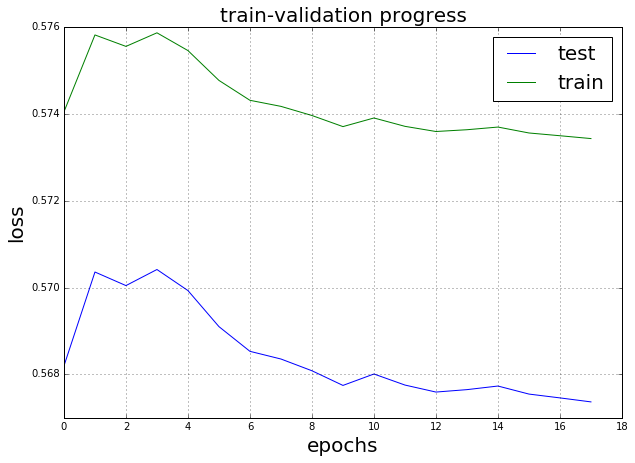

best scores train: 0.57343
best scores test: 0.56737


In [12]:
plt.figure(figsize=(10,7))
plt.plot(score_test)
plt.plot(score_train)
plt.title('train-validation progress',fontsize=20)
plt.legend(('test','train'), loc = 'upper right',fontsize=20)
plt.xlabel('epochs',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid(True)
plt.show()

print 'best scores train: %.5f' %(np.min(score_train))
print 'best scores test: %.5f' %(np.min(score_test))

In [13]:
# validation 
print('-'*50)
print('wait to predict ...')

# load best weights
model.load_weights(path2weights)

s_train=[]
for n1 in range(0,len(X_train),step):
    X_train_r=preprocess(X_train[n1:n1+step],param_prep)
    y_train_r=y_train[n1:n1+step]
    s_train.append(model.evaluate(X_train_r, y_train_r,verbose=0))
    
s_test=[]
for n1 in range(0,len(X_test),step):
    X_test_r=preprocess(X_test[n1:n1+step],param_prep)
    y_test_r=y_test[n1:n1+step]
    s_test.append(model.evaluate(X_test_r, y_test_r,verbose=0))

print 'loss train: %.5f, loss test: %.5f ' %(np.mean(s_train),np.mean(s_test))  

--------------------------------------------------
wait to predict ...
loss train: 0.57343, loss test: 0.56737 


In [14]:
print 'wait to predict ...'
X=X_test

y_pred=np.zeros_like(y_test)
for n1 in range(0,len(X_test),step):
    X_test_r=preprocess(X_test[n1:n1+step],param_prep)
    y_test_r=y_test[n1:n1+step]
    y_pred[n1:n1+step]= model.predict(X_test_r)
    
print 'predict ready!'
print 'output shape:', y_pred.shape


# accuracy
y1 = np.argmax(y_test,axis=1)
y2=np.argmax(y_pred,axis=1)
diff = y1-y2
print diff.shape

n_tot = y1.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)

wait to predict ...
predict ready!
output shape: (280, 2)
(280,)
Accuracy: 74.64 pct (209 of 280) right


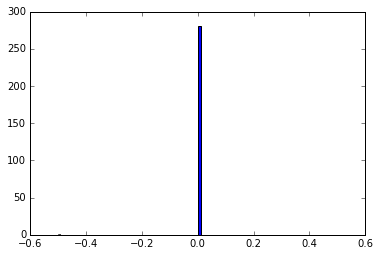

In [17]:
plt.hist(y2,bins=100)
plt.show()